## **Klasifikasi Audio Suara Hewan Imitasi menggunakan CNN 🐮🐱🐶🐐🐦**

In [3]:
# 1: Import library
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import librosa
import sounddevice as sd
import soundfile as sf
import matplotlib.pyplot as plt
from scipy.signal import welch

# 2: Parameters
SAMPLE_RATE = 32000
DURATION = 2  # seconds
NUM_SAMPLES = SAMPLE_RATE * DURATION
ANIMALS = ['moo', 'meow', 'woof', 'mbee', 'tweet']
DATA_DIR = './data'
os.makedirs(DATA_DIR, exist_ok=True)

### Insight
Cell ini melakukan import seluruh library yang dibutuhkan dan mendefinisikan parameter utama seperti sample rate, durasi audio, jumlah sample, serta daftar kelas suara hewan. Semua proses selanjutnya akan bergantung pada parameter dan library yang diinisialisasi di sini.

## Menyiapkan Dataset untuk Training Model
Dataset yang digunakan akan didapatkan menggunakan rekaman suara secara langsung, yang mana akan diminta untuk merekam huruf vokal moo, meow, woof, mbee, dan tweet sebanyak 15x setiap vokalnya.

In [4]:
# 3: Fungsi Recording untuk Merekam Data
def record_sample(animal, idx):
    print(f"Recording {animal} sample {idx + 1}/{5 + 10}...")
    recording = sd.rec(NUM_SAMPLES, samplerate=SAMPLE_RATE, channels=1)
    sd.wait()
    filename = os.path.join(DATA_DIR, f"{animal}_{idx}.wav")
    sf.write(filename, recording, SAMPLE_RATE)
    return filename

# 4: Rekam Data untuk Setiap Animal
for animal in ANIMALS:
    os.makedirs(os.path.join(DATA_DIR, animal), exist_ok=True)
    # total 15 per animal (10 train, 5 test)
    for idx in range(15):
        path = record_sample(animal, idx)
        os.rename(path, os.path.join(DATA_DIR, animal, os.path.basename(path)))

Recording moo sample 1/15...
Recording moo sample 2/15...
Recording moo sample 2/15...
Recording moo sample 3/15...
Recording moo sample 3/15...
Recording moo sample 4/15...
Recording moo sample 4/15...
Recording moo sample 5/15...
Recording moo sample 5/15...
Recording moo sample 6/15...
Recording moo sample 6/15...
Recording moo sample 7/15...
Recording moo sample 7/15...
Recording moo sample 8/15...
Recording moo sample 8/15...
Recording moo sample 9/15...
Recording moo sample 9/15...
Recording moo sample 10/15...
Recording moo sample 10/15...
Recording moo sample 11/15...
Recording moo sample 11/15...
Recording moo sample 12/15...
Recording moo sample 12/15...
Recording moo sample 13/15...
Recording moo sample 13/15...
Recording moo sample 14/15...
Recording moo sample 14/15...
Recording moo sample 15/15...
Recording moo sample 15/15...
Recording meow sample 1/15...
Recording meow sample 1/15...
Recording meow sample 2/15...
Recording meow sample 2/15...
Recording meow sample 3/15.

### Insight
Cell ini berfungsi untuk merekam data audio dari setiap kelas hewan (moo, meow, woof, mbee, tweet) sebanyak 15 kali per kelas. Hasil rekaman akan digunakan sebagai dataset utama untuk proses training dan evaluasi model.

## Pre-processing Dataset dan Ekstraksi Fitur 🔍
Tujuan tahap ini ialah untuk menyiapkan data mentah menjadi fitur siap model. Pre-processing meliputi proses:
- **VAD** (Voice Activity Detection) untuk membuang silent segments  
- **Padding/cropping** agar durasi konsisten  
- **Normalisasi amplitudo**  
- Ekstraksi **MFCC** (40 koefisien), distandarisasi
- Membuat Custom Dataset dan Menyimpan pasangan (MFCC, label)  
- Memisahkan dataset menjadi train (10 data) dan test (5 data)
- Definisi Arsitektur CNN

In [5]:
# 5: Preprocessing Audio Preprocessing dengan VAD dan Feature Extraction
def preprocess_audio(file_path, sr=SAMPLE_RATE, num_samples=NUM_SAMPLES, top_db=20):
    y, _ = librosa.load(file_path, sr=sr)
    intervals = librosa.effects.split(y, top_db=top_db)
    if intervals.size:
        y = np.concatenate([y[start:end] for start, end in intervals])
    if len(y) < num_samples:
        y = np.pad(y, (0, num_samples - len(y)))
    else:
        y = y[:num_samples]
    max_amp = np.max(np.abs(y)) + 1e-6
    y = y / max_amp
    return y


def extract_features(file_path):
    y = preprocess_audio(file_path)
    mfcc = librosa.feature.mfcc(y=y, sr=SAMPLE_RATE, n_mfcc=40)
    mfcc = (mfcc - np.mean(mfcc)) / (np.std(mfcc) + 1e-6)
    return mfcc.astype(np.float32)

# 6: Custom Dataset
def gather_files():
    all_files = []
    for label_idx, animal in enumerate(ANIMALS):
        files = sorted(os.listdir(os.path.join(DATA_DIR, animal)))
        full = [os.path.join(DATA_DIR, animal, f) for f in files]
        all_files += [(f, label_idx) for f in full]
    return all_files

class AnimalDataset(Dataset):
    def __init__(self, file_label_pairs):
        self.data = []
        for f, label in file_label_pairs:
            feats = extract_features(f)
            self.data.append((feats[np.newaxis, ...], label))
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        x, y = self.data[idx]
        return torch.tensor(x), torch.tensor(y)

# 7: Menyiapkan DataLoaders
files = gather_files()
train_list, test_list = [], []
for a_idx, animal in enumerate(ANIMALS):
    fl = [p for p in files if p[1] == a_idx]
    train_list += fl[:10]
    test_list += fl[10:]

train_ds = AnimalDataset(train_list)
test_ds = AnimalDataset(test_list)

train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=16)

# 8: Definisikan CNN Model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        # compute output size
        dummy = torch.zeros(1,1,40, NUM_SAMPLES//512+1)
        out = self.conv(dummy)
        self.flatten_dim = out.numel()//out.shape[0]
        self.fc = nn.Linear(self.flatten_dim, len(ANIMALS))
    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)

### Insight
Cell ini melakukan preprocessing audio (VAD, normalisasi, padding/cropping), ekstraksi fitur MFCC, serta membangun custom dataset dan DataLoader. Hasilnya adalah data audio yang sudah siap digunakan untuk training dan evaluasi model CNN.

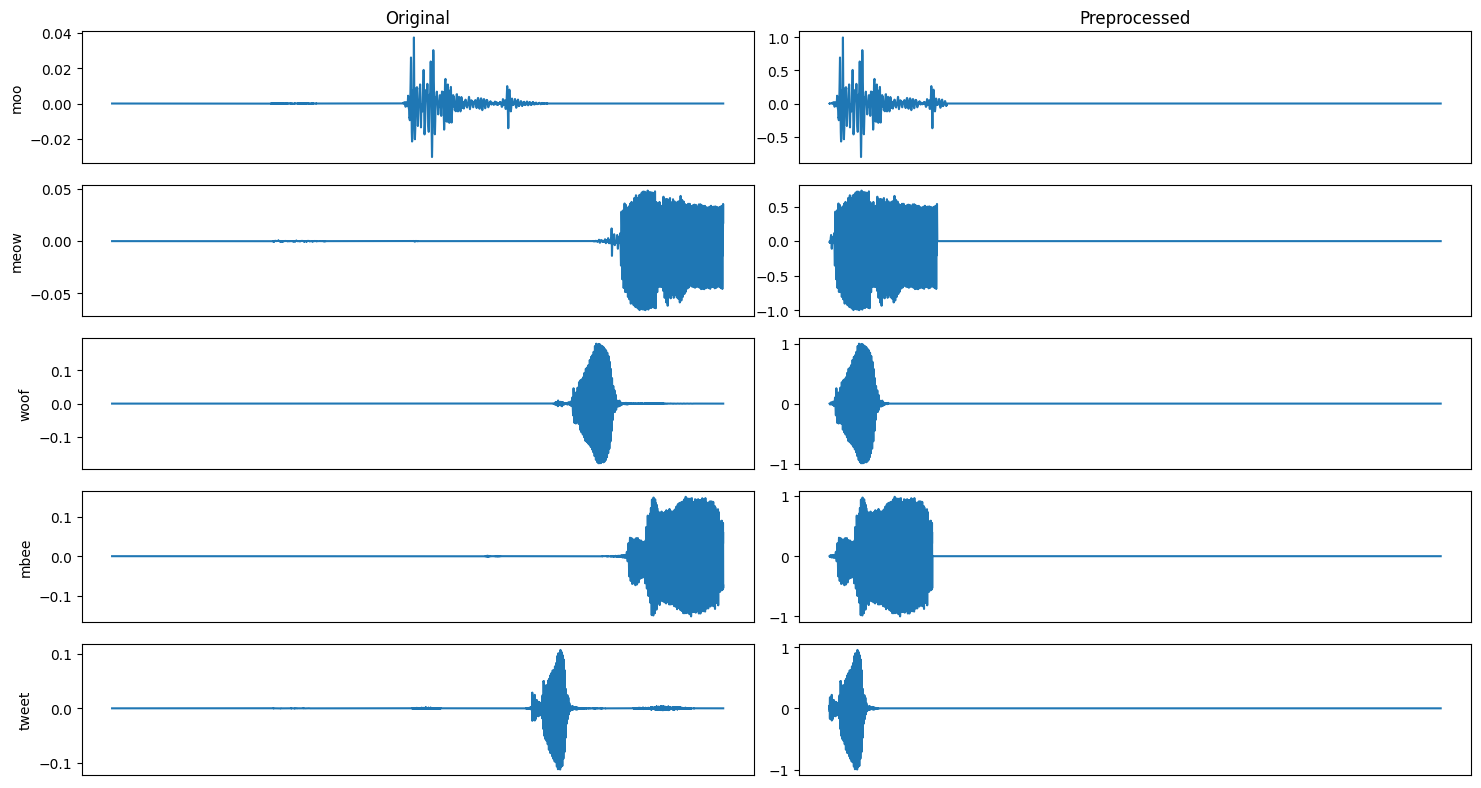

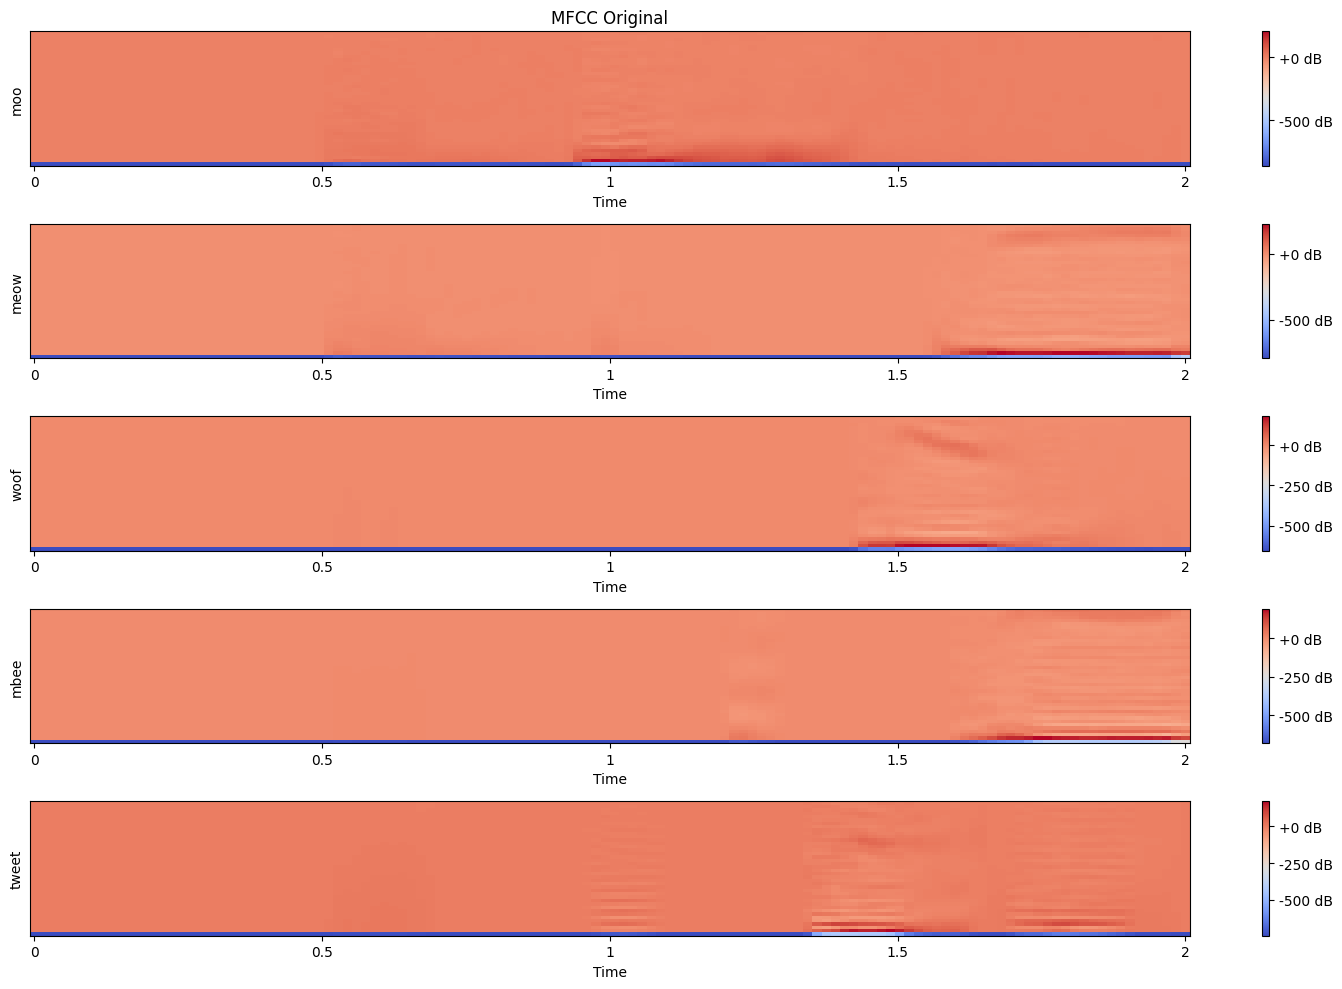

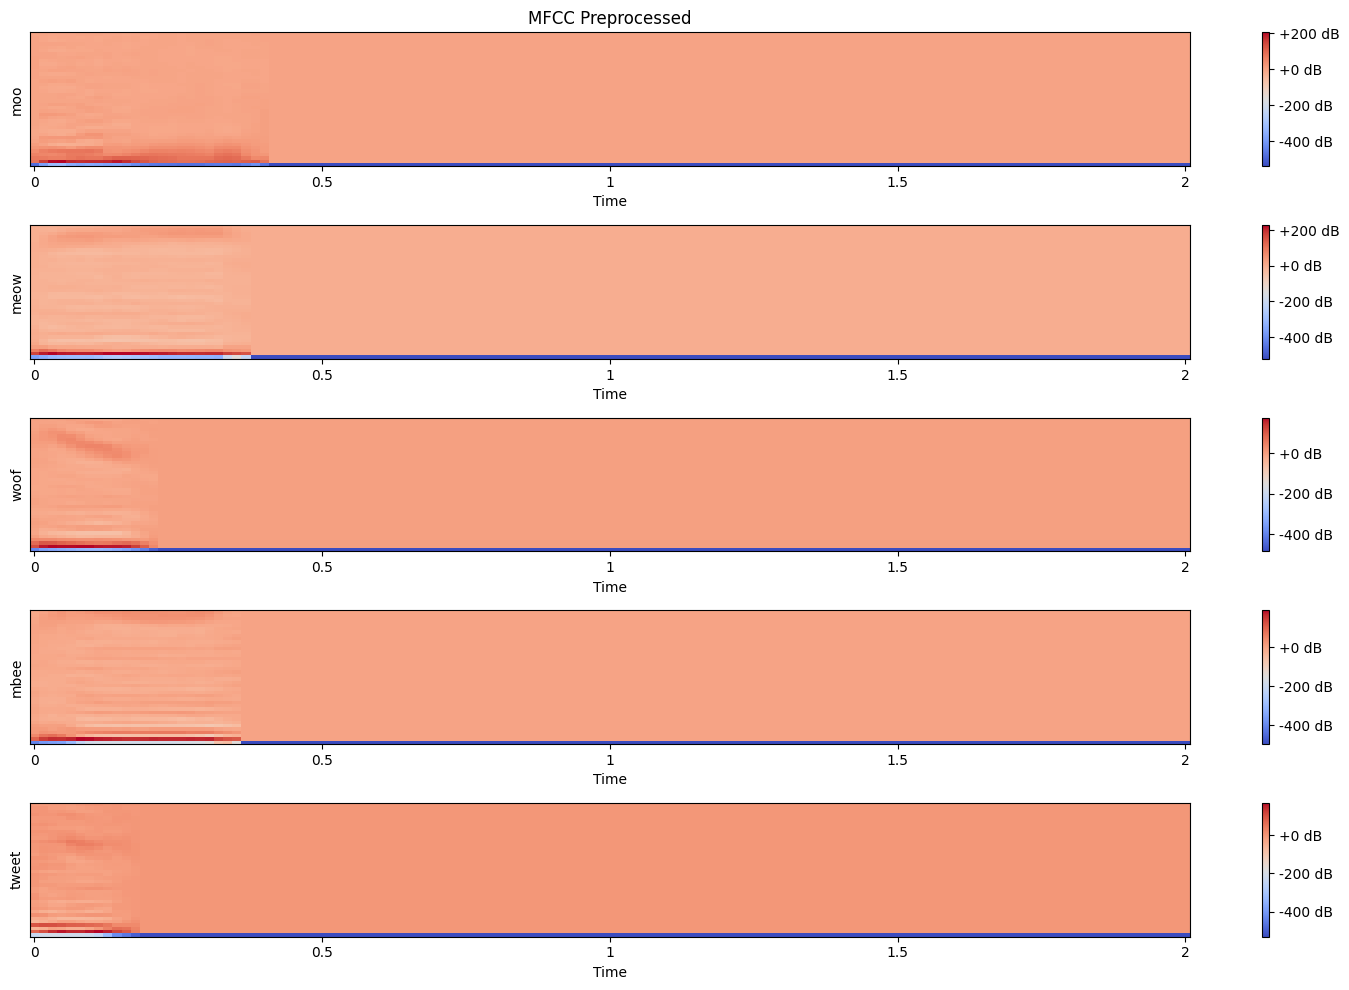

In [6]:
# Perbandingan Bentuk Gelombang dan MFCC tiap Animal
files_by_animal = {a: sorted(os.listdir(os.path.join(DATA_DIR, a))) for a in ANIMALS}
sample_idx = 0

plt.figure(figsize=(15, 8))
for i, a in enumerate(ANIMALS):
    fpath = os.path.join(DATA_DIR, a, files_by_animal[a][sample_idx])
    y_o, _ = librosa.load(fpath, sr=SAMPLE_RATE)
    y_p = preprocess_audio(fpath)
    plt.subplot(len(ANIMALS), 2, 2*i+1)
    plt.plot(y_o)
    if i == 0: plt.title('Original')
    plt.ylabel(a)
    plt.xticks([])
    plt.subplot(len(ANIMALS), 2, 2*i+2)
    plt.plot(y_p)
    if i == 0: plt.title('Preprocessed')
    plt.xticks([])
plt.tight_layout()
plt.show()


for mode, y_func in [('Original', lambda f: librosa.load(f, sr=SAMPLE_RATE)[0][:NUM_SAMPLES]),
                     ('Preprocessed', lambda f: preprocess_audio(f))]:
    plt.figure(figsize=(15, 10))
    for i, a in enumerate(ANIMALS):
        fpath = os.path.join(DATA_DIR, a, files_by_animal[a][sample_idx])
        y = y_func(fpath)
        mfcc = librosa.feature.mfcc(y=y, sr=SAMPLE_RATE, n_mfcc=40)
        plt.subplot(len(ANIMALS), 1, i+1)
        librosa.display.specshow(mfcc, sr=SAMPLE_RATE, x_axis='time')
        plt.colorbar(format='%+2.0f dB')
        plt.ylabel(a)
        if i == 0: plt.title(f'MFCC {mode}')
        else: plt.title('')
    plt.tight_layout()
    plt.show()


### Insight
Visualisasi ini memperlihatkan bentuk gelombang asli dan hasil preprocessing, serta MFCC dari masing-masing kelas suara hewan. Dari grafik ini, kita dapat melihat perbedaan karakteristik audio tiap kelas yang akan membantu model dalam proses klasifikasi.

### Sumber Referensi Frekuensi: https://biomed.papers.upol.cz/pdfs/bio/2007/02/31.pdf


Detected Formants vs Theoretical Ranges per Vowel:
moo: Detected F1 = 875.0 Hz [Range: 850-1150 Hz]
    Detected F2 = 2000.0 Hz [Range: 1200-2000 Hz]
meow: Detected F1 = 812.5 Hz [Range: 700-950 Hz]
    Detected F2 = 2187.5 Hz [Range: 1700-3000 Hz]
woof: Detected F1 = 437.5 Hz [Range: 300-450 Hz]
    Detected F2 = 3218.8 Hz [Range: 2000-3600 Hz]
mbee: Detected F1 = 625.0 Hz [Range: 600-800 Hz]
    Detected F2 = 625.0 Hz [Range: 600-1400 Hz]
moo: Detected F1 = 875.0 Hz [Range: 850-1150 Hz]
    Detected F2 = 2000.0 Hz [Range: 1200-2000 Hz]
meow: Detected F1 = 812.5 Hz [Range: 700-950 Hz]
    Detected F2 = 2187.5 Hz [Range: 1700-3000 Hz]
woof: Detected F1 = 437.5 Hz [Range: 300-450 Hz]
    Detected F2 = 3218.8 Hz [Range: 2000-3600 Hz]
mbee: Detected F1 = 625.0 Hz [Range: 600-800 Hz]
    Detected F2 = 625.0 Hz [Range: 600-1400 Hz]
tweet: Detected F1 = 281.2 Hz [Range: 100-400 Hz]
    Detected F2 = 562.5 Hz [Range: 400-1200 Hz]
tweet: Detected F1 = 281.2 Hz [Range: 100-400 Hz]
    Detected

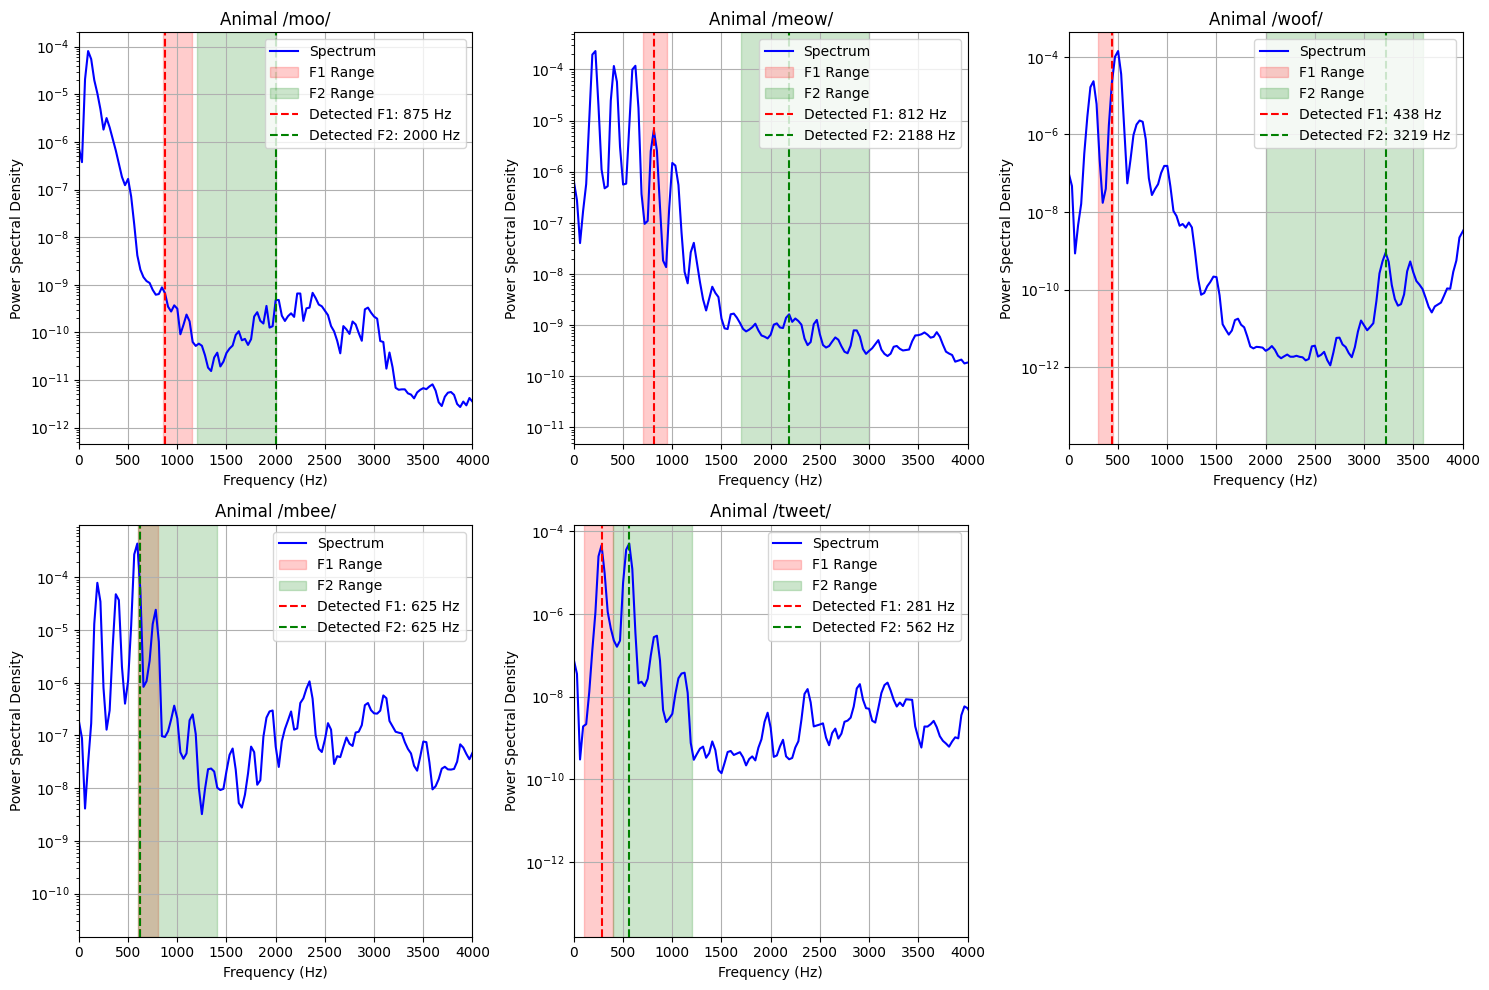

In [8]:
# Define theoretical formant ranges
vowel_ranges = {
    'moo': {'F1': (850, 1150), 'F2': (1200, 2000)},
    'meow': {'F1': (700, 950), 'F2': (1700, 3000)},
    'woof': {'F1': (300, 450), 'F2': (2000, 3600)},
    'mbee': {'F1': (600, 800), 'F2': (600, 1400)},
    'tweet': {'F1': (100, 400), 'F2': (400, 1200)}
}

# Create figure for visualizations
plt.figure(figsize=(15, 10))
plot_idx = 1

print("\nDetected Formants vs Theoretical Ranges per Vowel:")
for v in ANIMALS:
    fpath = os.path.join(DATA_DIR, v, files_by_animal[v][sample_idx])
    y = preprocess_audio(fpath)
    f, Pxx = welch(y, fs=SAMPLE_RATE, nperseg=1024)

    # Find formants within theoretical ranges
    f1_range = vowel_ranges.get(v, {'F1': (0,0)})['F1']
    f2_range = vowel_ranges.get(v, {'F2': (0,0)})['F2']

    # Mask for formant ranges
    mask_f1 = (f >= f1_range[0]) & (f <= f1_range[1])
    mask_f2 = (f >= f2_range[0]) & (f <= f2_range[1])

    # Detect F1 and F2 (frequency with max power in each range)
    f1_detected = f[mask_f1][np.argmax(Pxx[mask_f1])] if any(mask_f1) else np.nan
    f2_detected = f[mask_f2][np.argmax(Pxx[mask_f2])] if any(mask_f2) else np.nan

    # Create subplot for current animal
    plt.subplot(2, 3, plot_idx)
    plt.semilogy(f, Pxx, 'b-', label='Spectrum')

    # Highlight theoretical ranges
    plt.axvspan(*f1_range, color='r', alpha=0.2, label='F1 Range')
    plt.axvspan(*f2_range, color='g', alpha=0.2, label='F2 Range')

    # Mark detected formants
    if not np.isnan(f1_detected):
        plt.axvline(f1_detected, color='red', linestyle='--', label=f'Detected F1: {f1_detected:.0f} Hz')
    if not np.isnan(f2_detected):
        plt.axvline(f2_detected, color='green', linestyle='--', label=f'Detected F2: {f2_detected:.0f} Hz')

    plt.title(f'Animal /{v}/')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Power Spectral Density')
    plt.xlim(0, 4000)
    plt.grid(True)
    plt.legend(loc='upper right')

    # Print results
    print(f"{v}: Detected F1 = {f1_detected:.1f} Hz [Range: {f1_range[0]}-{f1_range[1]} Hz]")
    print(f"    Detected F2 = {f2_detected:.1f} Hz [Range: {f2_range[0]}-{f2_range[1]} Hz]")

    plot_idx += 1

plt.tight_layout()
plt.savefig('animal_formants_comparison.png')
plt.show()

### Insight
Analisis formant pada cell ini mencoba membandingkan spektrum frekuensi suara hewan dengan rentang teoritis formant. Namun, karena suara hewan berbeda dengan vokal manusia, hasil deteksi formant lebih bersifat ilustratif dan tidak selalu relevan untuk klasifikasi hewan.

### Kesimpulan Pre-Processing Data
1. Data telah dicleaning dan dinormalisasikan (terlihat dari MFCC dan gelombang suara dimana noise telah berkurang dan ukuran panjang gelombang di normalisasikan)
2. Berdasarkan distribusi frekuensi, dataset yang digunakan telah baik, ditunjukkan pada grafik dimana frekuensi F1 dan F2 tiap vokal pada data berada dalam rentang yang seharusnya sesuai secara teoritikal nya

## **TRAINING MODEL** 📈

Using device: cpu
Epoch 100/100, Loss: 0.0012, Train Acc: 100.00%, Test Acc: 100.00%



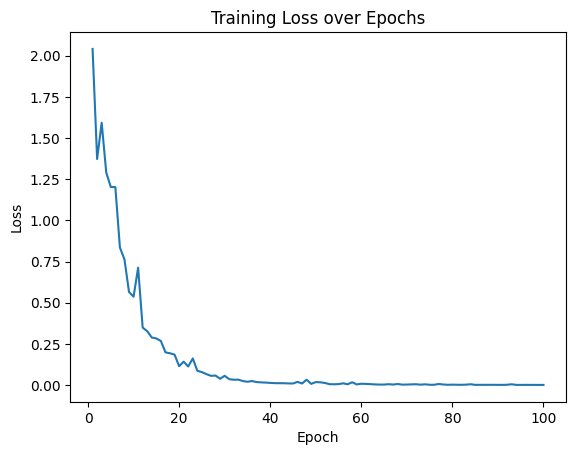

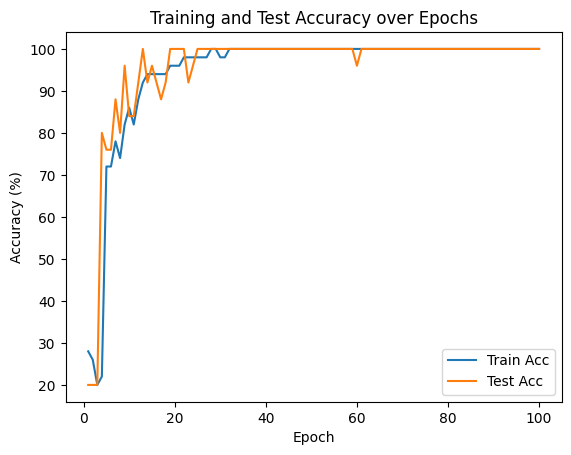

In [9]:
### 9: Training Model
import sys

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 100
# Initialize lists to store metrics
train_losses, train_accs, test_accs = [], [], []

for epoch in range(epochs):
    model.train()
    total_loss = 0.0
    correct_train = 0
    total_train = 0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        outputs = model(x)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        preds = outputs.argmax(dim=1)
        correct_train += (preds == y).sum().item()
        total_train += y.size(0)
    avg_loss = total_loss / len(train_loader)
    train_acc = 100.0 * correct_train / total_train

    # Evaluate on test set
    model.eval()
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for x_t, y_t in test_loader:
            x_t, y_t = x_t.to(device), y_t.to(device)
            out_t = model(x_t)
            preds_t = out_t.argmax(dim=1)
            correct_test += (preds_t == y_t).sum().item()
            total_test += y_t.size(0)
    test_acc = 100.0 * correct_test / total_test

    # Store metrics
    train_losses.append(avg_loss)
    train_accs.append(train_acc)
    test_accs.append(test_acc)

    # Progress
    sys.stdout.write(
        f"\rEpoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}, "
        f"Train Acc: {train_acc:.2f}%, Test Acc: {test_acc:.2f}%"
    )
    sys.stdout.flush()
print()

epochs_range = range(1, epochs + 1)
# Plot loss
plt.figure()
plt.plot(epochs_range, train_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.show()

# Plot accuracy
plt.figure()
plt.plot(epochs_range, train_accs, label='Train Acc')
plt.plot(epochs_range, test_accs, label='Test Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Test Accuracy over Epochs')
plt.legend()
plt.show()


### Insight
Cell ini melakukan training model CNN untuk klasifikasi suara hewan. Grafik loss dan akurasi menunjukkan seberapa baik model belajar dari data. Jika loss menurun dan akurasi meningkat, berarti model berhasil mempelajari pola dari data training.

In [10]:
# 10: Evaluasi Kinerja Model
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        outputs = model(x)
        _, preds = torch.max(outputs, 1)
        correct += (preds == y).sum().item()
        total += y.size(0)
print(f"Test Accuracy: {correct/total*100:.2f}% \n")

# Cell 11: Classification Report
from sklearn.metrics import classification_report
all_preds, all_labels = [], []
with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        out = model(x)
        _, pred = torch.max(out, 1)
        all_preds += pred.cpu().tolist()
        all_labels += y.tolist()
print(classification_report(all_labels, all_preds, target_names=ANIMALS))

Test Accuracy: 100.00% 

              precision    recall  f1-score   support

         moo       1.00      1.00      1.00         5
        meow       1.00      1.00      1.00         5
        woof       1.00      1.00      1.00         5
        mbee       1.00      1.00      1.00         5
       tweet       1.00      1.00      1.00         5

    accuracy                           1.00        25
   macro avg       1.00      1.00      1.00        25
weighted avg       1.00      1.00      1.00        25



### Insight
Cell ini mengevaluasi performa model pada data test. Akurasi dan classification report menunjukkan seberapa baik model membedakan suara hewan pada data yang belum pernah dilihat. Nilai precision, recall, dan f1-score yang tinggi menandakan model sangat baik dalam klasifikasi.

In [11]:
# Cell 12: Save Model
torch.save(model.state_dict(), 'animal_cnn.pth')
print("Model disimpan!")

Model disimpan!


### Insight
Model yang sudah terlatih disimpan ke file agar bisa digunakan kembali untuk prediksi suara hewan tanpa perlu training ulang. Ini memudahkan deployment dan pengujian model di masa depan.

Berdasarkan training serta evaluasi yang telah dilakukan, didapatkan model memiliki performa yang sangat baik yakni mencapai **100%** di semua evaluation metrics. Namun tentunya, mengingat dataset yang digunakan hanya sedikit, penting untuk menjadi pertimbangan pengujian kedepannya dengan menggunakan dataset yang lebih banyak dan variatif 🧮

#### **UJI COBA KLASIFIKASI SUARA VOKAL DENGAN MODEL YANG TELAH DIBUAT** 🚀

In [17]:
# 13: Test Prediction via Recording dengan menampilkan confidence tiap label
import torch.nn.functional as F

def predict_from_record():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = CNN().to(device)
    model.load_state_dict(torch.load('./animal_cnn.pth', map_location=device))

    print("Ucapkan suara hewan (moo/meow/woof/mbee/tweet)...")
    rec = sd.rec(NUM_SAMPLES, samplerate=SAMPLE_RATE, channels=1)
    sd.wait()
    temp_path = 'temp.wav'
    sf.write(temp_path, rec, SAMPLE_RATE)

    feats = extract_features(temp_path)
    x = torch.tensor(feats[np.newaxis, np.newaxis, ...]).to(device)

    model.eval()
    with torch.no_grad():
        out = model(x)                     # raw logits
        probs = F.softmax(out, dim=1)[0]   # probability per class

    # tampilkan persentase untuk tiap animal
    for idx, animal in enumerate(ANIMALS):
        print(f"{animal}: {probs[idx].item()*100:.2f}%")

    # prediksi tertinggi
    pred_idx = probs.argmax().item()
    print(f"\nSuara Hewan Yang Diprediksi: {ANIMALS[pred_idx]}")

predict_from_record()


Ucapkan suara hewan (moo/meow/woof/mbee/tweet)...
moo: 0.34%
meow: 2.45%
woof: 15.40%
mbee: 81.11%
tweet: 0.70%

Suara Hewan Yang Diprediksi: mbee
moo: 0.34%
meow: 2.45%
woof: 15.40%
mbee: 81.11%
tweet: 0.70%

Suara Hewan Yang Diprediksi: mbee


### Insight
Cell ini menguji model dengan merekam suara hewan baru dan menampilkan prediksi beserta confidence untuk setiap kelas. Hasil prediksi membantu mengetahui seberapa yakin model dalam mengklasifikasikan suara yang diberikan.